# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

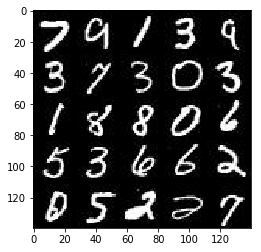

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

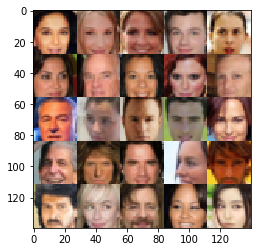

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [31]:
def leakyrelu(net, alpha = 0.2, name = 'leaky_relu'):    
    return tf.maximum(alpha * net, net, name=name)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    is_training = True
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = leakyrelu(conv1)

        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=1, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_training)
        conv2 = tf.layers.dropout(conv2, rate=0.5, training=is_training)
        conv2 = leakyrelu(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 256, 5, strides=2, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_training)
        conv3 = tf.layers.dropout(conv3, rate=0.5, training=is_training)
        conv3 = leakyrelu(conv3)

        flattened = tf.reshape(conv3, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function    
    with tf.variable_scope('generator', reuse=not is_train):
        inputs = tf.layers.dense(z, 7 * 7 * 512)
        
        conv1 = tf.reshape(inputs, (-1, 7, 7, 512))        
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leakyrelu(conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=2, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.layers.dropout(conv2, rate=0.8, training=is_train)
        conv2 = leakyrelu(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=1, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.layers.dropout(conv3, rate=0.8, training=is_train)
        conv3 = leakyrelu(conv3)
        
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='SAME')
        
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.random_uniform(tf.shape(d_model_real),0.7,1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_real_scaled = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_real_scaled, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate, input_real: batch_real_scaled})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate, input_real: batch_real_scaled})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_real_scaled})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch: {}/{}({})...'.format(epoch_i+1, epochs, steps),
                         'Discriminator Loss: {:4f}...'.format(d_train_loss),
                         'Generator Loss: {:4f}'.format(g_train_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2(10)... Discriminator Loss: 1.865460... Generator Loss: 0.717469
Epoch: 1/2(20)... Discriminator Loss: 1.958566... Generator Loss: 0.605000
Epoch: 1/2(30)... Discriminator Loss: 1.453474... Generator Loss: 1.096616
Epoch: 1/2(40)... Discriminator Loss: 1.665450... Generator Loss: 0.894865
Epoch: 1/2(50)... Discriminator Loss: 1.550925... Generator Loss: 1.112988
Epoch: 1/2(60)... Discriminator Loss: 1.510361... Generator Loss: 1.180115
Epoch: 1/2(70)... Discriminator Loss: 1.754425... Generator Loss: 0.506876
Epoch: 1/2(80)... Discriminator Loss: 1.487751... Generator Loss: 1.111612
Epoch: 1/2(90)... Discriminator Loss: 1.406282... Generator Loss: 0.959111
Epoch: 1/2(100)... Discriminator Loss: 1.547141... Generator Loss: 0.817465


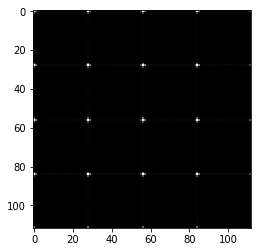

Epoch: 1/2(110)... Discriminator Loss: 1.543414... Generator Loss: 1.315658
Epoch: 1/2(120)... Discriminator Loss: 1.486992... Generator Loss: 0.658403
Epoch: 1/2(130)... Discriminator Loss: 1.408597... Generator Loss: 1.013454
Epoch: 1/2(140)... Discriminator Loss: 1.444119... Generator Loss: 0.662350
Epoch: 1/2(150)... Discriminator Loss: 1.433298... Generator Loss: 0.734163
Epoch: 1/2(160)... Discriminator Loss: 1.395437... Generator Loss: 0.597904
Epoch: 1/2(170)... Discriminator Loss: 1.348733... Generator Loss: 0.759634
Epoch: 1/2(180)... Discriminator Loss: 1.416769... Generator Loss: 0.854158
Epoch: 1/2(190)... Discriminator Loss: 1.647239... Generator Loss: 0.446922
Epoch: 1/2(200)... Discriminator Loss: 1.298514... Generator Loss: 0.755437


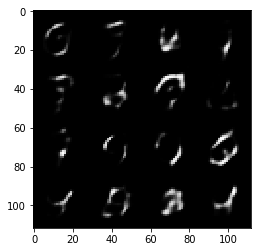

Epoch: 1/2(210)... Discriminator Loss: 1.405832... Generator Loss: 0.692102
Epoch: 1/2(220)... Discriminator Loss: 1.418651... Generator Loss: 1.191048
Epoch: 1/2(230)... Discriminator Loss: 1.387077... Generator Loss: 0.721647
Epoch: 1/2(240)... Discriminator Loss: 1.408737... Generator Loss: 0.804203
Epoch: 1/2(250)... Discriminator Loss: 1.427730... Generator Loss: 0.601313
Epoch: 1/2(260)... Discriminator Loss: 1.369402... Generator Loss: 0.722175
Epoch: 1/2(270)... Discriminator Loss: 1.371922... Generator Loss: 0.669241
Epoch: 1/2(280)... Discriminator Loss: 1.593486... Generator Loss: 1.369490
Epoch: 1/2(290)... Discriminator Loss: 1.393821... Generator Loss: 0.908565
Epoch: 1/2(300)... Discriminator Loss: 1.389082... Generator Loss: 1.171506


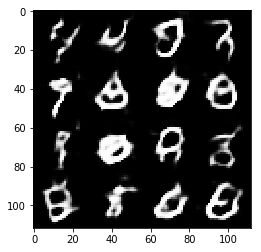

Epoch: 1/2(310)... Discriminator Loss: 1.404259... Generator Loss: 0.952381
Epoch: 1/2(320)... Discriminator Loss: 1.322448... Generator Loss: 0.952490
Epoch: 1/2(330)... Discriminator Loss: 1.379292... Generator Loss: 0.817910
Epoch: 1/2(340)... Discriminator Loss: 1.376288... Generator Loss: 0.654174
Epoch: 1/2(350)... Discriminator Loss: 1.396772... Generator Loss: 0.968184
Epoch: 1/2(360)... Discriminator Loss: 1.542464... Generator Loss: 1.391973
Epoch: 1/2(370)... Discriminator Loss: 1.351458... Generator Loss: 0.920498
Epoch: 1/2(380)... Discriminator Loss: 1.370438... Generator Loss: 0.913721
Epoch: 1/2(390)... Discriminator Loss: 1.413770... Generator Loss: 0.695106
Epoch: 1/2(400)... Discriminator Loss: 1.365440... Generator Loss: 0.693869


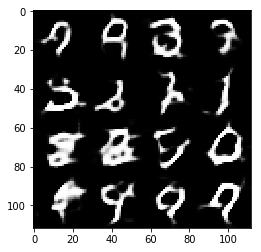

Epoch: 1/2(410)... Discriminator Loss: 1.329679... Generator Loss: 0.986939
Epoch: 1/2(420)... Discriminator Loss: 1.402559... Generator Loss: 0.655104
Epoch: 1/2(430)... Discriminator Loss: 1.433531... Generator Loss: 1.087890
Epoch: 1/2(440)... Discriminator Loss: 1.356861... Generator Loss: 0.910431
Epoch: 1/2(450)... Discriminator Loss: 1.319886... Generator Loss: 1.024469
Epoch: 1/2(460)... Discriminator Loss: 1.331456... Generator Loss: 0.876446
Epoch: 1/2(470)... Discriminator Loss: 1.330773... Generator Loss: 0.957310
Epoch: 1/2(480)... Discriminator Loss: 1.408340... Generator Loss: 0.529375
Epoch: 1/2(490)... Discriminator Loss: 1.348101... Generator Loss: 0.677968
Epoch: 1/2(500)... Discriminator Loss: 1.436542... Generator Loss: 1.134374


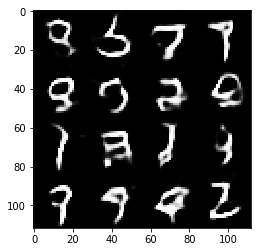

Epoch: 1/2(510)... Discriminator Loss: 1.381224... Generator Loss: 1.166177
Epoch: 1/2(520)... Discriminator Loss: 1.373118... Generator Loss: 0.706011
Epoch: 1/2(530)... Discriminator Loss: 1.646173... Generator Loss: 0.399859
Epoch: 1/2(540)... Discriminator Loss: 1.399015... Generator Loss: 0.817069
Epoch: 1/2(550)... Discriminator Loss: 1.347221... Generator Loss: 0.810801
Epoch: 1/2(560)... Discriminator Loss: 1.423420... Generator Loss: 0.590505
Epoch: 1/2(570)... Discriminator Loss: 1.341400... Generator Loss: 0.897478
Epoch: 1/2(580)... Discriminator Loss: 1.335680... Generator Loss: 0.801389
Epoch: 1/2(590)... Discriminator Loss: 1.411360... Generator Loss: 0.872217
Epoch: 1/2(600)... Discriminator Loss: 1.286239... Generator Loss: 0.833972


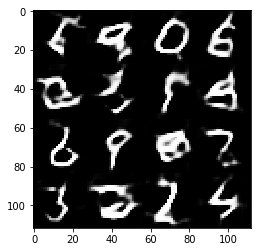

Epoch: 1/2(610)... Discriminator Loss: 1.397285... Generator Loss: 0.620538
Epoch: 1/2(620)... Discriminator Loss: 1.369594... Generator Loss: 1.172310
Epoch: 1/2(630)... Discriminator Loss: 1.321019... Generator Loss: 0.875680
Epoch: 1/2(640)... Discriminator Loss: 1.411894... Generator Loss: 0.550369
Epoch: 1/2(650)... Discriminator Loss: 1.316891... Generator Loss: 1.001692
Epoch: 1/2(660)... Discriminator Loss: 1.316728... Generator Loss: 0.721176
Epoch: 1/2(670)... Discriminator Loss: 1.322445... Generator Loss: 1.031493
Epoch: 1/2(680)... Discriminator Loss: 1.372776... Generator Loss: 0.689583
Epoch: 1/2(690)... Discriminator Loss: 1.459438... Generator Loss: 0.582602
Epoch: 1/2(700)... Discriminator Loss: 1.286932... Generator Loss: 0.884181


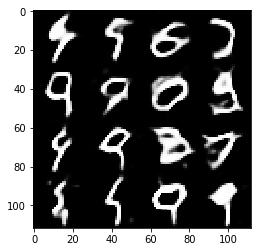

Epoch: 1/2(710)... Discriminator Loss: 1.348355... Generator Loss: 0.657828
Epoch: 1/2(720)... Discriminator Loss: 1.385636... Generator Loss: 0.594793
Epoch: 1/2(730)... Discriminator Loss: 1.331892... Generator Loss: 0.768505
Epoch: 1/2(740)... Discriminator Loss: 1.426945... Generator Loss: 0.493183
Epoch: 1/2(750)... Discriminator Loss: 1.255753... Generator Loss: 0.832179
Epoch: 1/2(760)... Discriminator Loss: 1.675601... Generator Loss: 1.693639
Epoch: 1/2(770)... Discriminator Loss: 1.342363... Generator Loss: 0.744906
Epoch: 1/2(780)... Discriminator Loss: 1.305948... Generator Loss: 0.812571
Epoch: 1/2(790)... Discriminator Loss: 1.352836... Generator Loss: 0.774322
Epoch: 1/2(800)... Discriminator Loss: 1.394828... Generator Loss: 0.811876


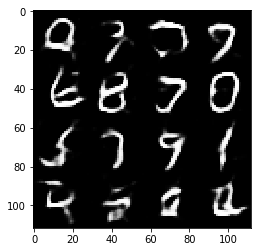

Epoch: 1/2(810)... Discriminator Loss: 1.334942... Generator Loss: 0.734890
Epoch: 1/2(820)... Discriminator Loss: 1.328692... Generator Loss: 1.149046
Epoch: 1/2(830)... Discriminator Loss: 1.364922... Generator Loss: 1.273014
Epoch: 1/2(840)... Discriminator Loss: 1.244994... Generator Loss: 0.908852
Epoch: 1/2(850)... Discriminator Loss: 1.248039... Generator Loss: 0.859402
Epoch: 1/2(860)... Discriminator Loss: 1.283188... Generator Loss: 0.840715
Epoch: 1/2(870)... Discriminator Loss: 1.298465... Generator Loss: 0.681506
Epoch: 1/2(880)... Discriminator Loss: 1.368700... Generator Loss: 0.593748
Epoch: 1/2(890)... Discriminator Loss: 1.280342... Generator Loss: 0.710547
Epoch: 1/2(900)... Discriminator Loss: 1.400393... Generator Loss: 0.586670


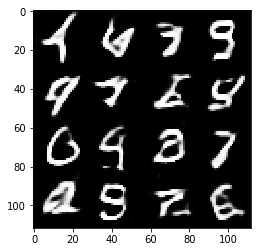

Epoch: 1/2(910)... Discriminator Loss: 1.230442... Generator Loss: 0.803751
Epoch: 1/2(920)... Discriminator Loss: 1.207329... Generator Loss: 0.819168
Epoch: 1/2(930)... Discriminator Loss: 1.224993... Generator Loss: 0.980854
Epoch: 2/2(10)... Discriminator Loss: 1.229650... Generator Loss: 0.976189
Epoch: 2/2(20)... Discriminator Loss: 1.279661... Generator Loss: 0.844123
Epoch: 2/2(30)... Discriminator Loss: 1.402725... Generator Loss: 0.523514
Epoch: 2/2(40)... Discriminator Loss: 1.325994... Generator Loss: 0.728342
Epoch: 2/2(50)... Discriminator Loss: 1.280167... Generator Loss: 1.079655
Epoch: 2/2(60)... Discriminator Loss: 1.262445... Generator Loss: 0.700276
Epoch: 2/2(70)... Discriminator Loss: 1.250470... Generator Loss: 1.012589
Epoch: 2/2(80)... Discriminator Loss: 1.171141... Generator Loss: 0.939210
Epoch: 2/2(90)... Discriminator Loss: 1.321833... Generator Loss: 0.695356
Epoch: 2/2(100)... Discriminator Loss: 1.266430... Generator Loss: 0.577170


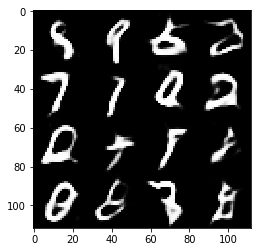

Epoch: 2/2(110)... Discriminator Loss: 1.143400... Generator Loss: 1.130787
Epoch: 2/2(120)... Discriminator Loss: 1.408895... Generator Loss: 0.526405
Epoch: 2/2(130)... Discriminator Loss: 1.292921... Generator Loss: 0.687814
Epoch: 2/2(140)... Discriminator Loss: 1.175706... Generator Loss: 0.773376
Epoch: 2/2(150)... Discriminator Loss: 1.303103... Generator Loss: 0.936023
Epoch: 2/2(160)... Discriminator Loss: 1.178118... Generator Loss: 1.235284
Epoch: 2/2(170)... Discriminator Loss: 1.336467... Generator Loss: 1.241196
Epoch: 2/2(180)... Discriminator Loss: 1.191993... Generator Loss: 0.795803
Epoch: 2/2(190)... Discriminator Loss: 1.368755... Generator Loss: 1.626803
Epoch: 2/2(200)... Discriminator Loss: 1.189543... Generator Loss: 0.803138


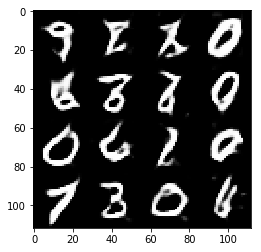

Epoch: 2/2(210)... Discriminator Loss: 1.159688... Generator Loss: 0.793563
Epoch: 2/2(220)... Discriminator Loss: 1.249697... Generator Loss: 0.697092
Epoch: 2/2(230)... Discriminator Loss: 1.074179... Generator Loss: 0.872109
Epoch: 2/2(240)... Discriminator Loss: 2.028720... Generator Loss: 2.633087
Epoch: 2/2(250)... Discriminator Loss: 1.090984... Generator Loss: 1.084392
Epoch: 2/2(260)... Discriminator Loss: 1.069440... Generator Loss: 1.128152
Epoch: 2/2(270)... Discriminator Loss: 1.466535... Generator Loss: 1.383386
Epoch: 2/2(280)... Discriminator Loss: 1.294797... Generator Loss: 0.967781
Epoch: 2/2(290)... Discriminator Loss: 1.112949... Generator Loss: 0.760347
Epoch: 2/2(300)... Discriminator Loss: 1.299918... Generator Loss: 0.693360


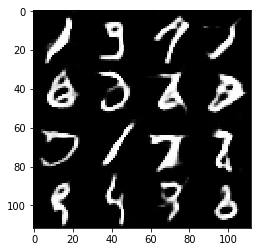

Epoch: 2/2(310)... Discriminator Loss: 1.091717... Generator Loss: 0.835611
Epoch: 2/2(320)... Discriminator Loss: 1.222875... Generator Loss: 0.671871
Epoch: 2/2(330)... Discriminator Loss: 1.149651... Generator Loss: 0.797001
Epoch: 2/2(340)... Discriminator Loss: 1.170256... Generator Loss: 1.811790
Epoch: 2/2(350)... Discriminator Loss: 1.384141... Generator Loss: 0.720018
Epoch: 2/2(360)... Discriminator Loss: 1.098307... Generator Loss: 1.386294
Epoch: 2/2(370)... Discriminator Loss: 1.078639... Generator Loss: 0.801332
Epoch: 2/2(380)... Discriminator Loss: 1.046262... Generator Loss: 1.200221
Epoch: 2/2(390)... Discriminator Loss: 1.093028... Generator Loss: 1.192307
Epoch: 2/2(400)... Discriminator Loss: 0.915242... Generator Loss: 1.143061


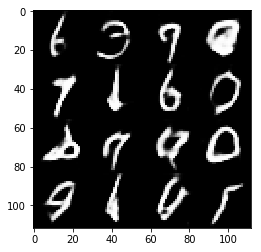

Epoch: 2/2(410)... Discriminator Loss: 1.121967... Generator Loss: 1.568521
Epoch: 2/2(420)... Discriminator Loss: 0.930149... Generator Loss: 1.490879
Epoch: 2/2(430)... Discriminator Loss: 0.974010... Generator Loss: 1.598073
Epoch: 2/2(440)... Discriminator Loss: 1.263664... Generator Loss: 0.707071
Epoch: 2/2(450)... Discriminator Loss: 0.882224... Generator Loss: 1.075369
Epoch: 2/2(460)... Discriminator Loss: 0.890017... Generator Loss: 1.176755
Epoch: 2/2(470)... Discriminator Loss: 1.178997... Generator Loss: 0.760968
Epoch: 2/2(480)... Discriminator Loss: 0.820017... Generator Loss: 1.123196
Epoch: 2/2(490)... Discriminator Loss: 1.016917... Generator Loss: 1.299898
Epoch: 2/2(500)... Discriminator Loss: 1.312223... Generator Loss: 0.787290


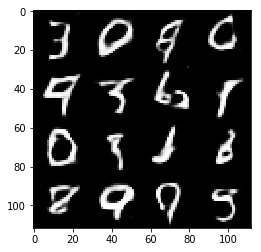

Epoch: 2/2(510)... Discriminator Loss: 0.866701... Generator Loss: 1.374272
Epoch: 2/2(520)... Discriminator Loss: 0.970070... Generator Loss: 1.144121
Epoch: 2/2(530)... Discriminator Loss: 0.967693... Generator Loss: 1.006860
Epoch: 2/2(540)... Discriminator Loss: 0.872354... Generator Loss: 1.385842
Epoch: 2/2(550)... Discriminator Loss: 0.900341... Generator Loss: 1.292565
Epoch: 2/2(560)... Discriminator Loss: 1.205221... Generator Loss: 0.857422
Epoch: 2/2(570)... Discriminator Loss: 0.954130... Generator Loss: 1.610086
Epoch: 2/2(580)... Discriminator Loss: 0.817823... Generator Loss: 1.588608
Epoch: 2/2(590)... Discriminator Loss: 2.515725... Generator Loss: 0.181842
Epoch: 2/2(600)... Discriminator Loss: 1.068164... Generator Loss: 1.262735


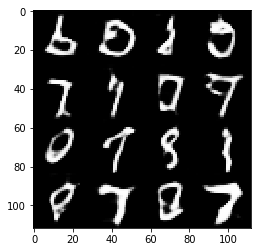

Epoch: 2/2(610)... Discriminator Loss: 0.741510... Generator Loss: 1.506709
Epoch: 2/2(620)... Discriminator Loss: 1.221701... Generator Loss: 1.871151
Epoch: 2/2(630)... Discriminator Loss: 0.901955... Generator Loss: 0.993264
Epoch: 2/2(640)... Discriminator Loss: 1.424313... Generator Loss: 0.528460
Epoch: 2/2(650)... Discriminator Loss: 0.764410... Generator Loss: 1.346692
Epoch: 2/2(660)... Discriminator Loss: 0.709904... Generator Loss: 1.302450
Epoch: 2/2(670)... Discriminator Loss: 1.003724... Generator Loss: 1.105969
Epoch: 2/2(680)... Discriminator Loss: 0.791748... Generator Loss: 2.152251
Epoch: 2/2(690)... Discriminator Loss: 0.749545... Generator Loss: 2.059922
Epoch: 2/2(700)... Discriminator Loss: 0.856290... Generator Loss: 1.055800


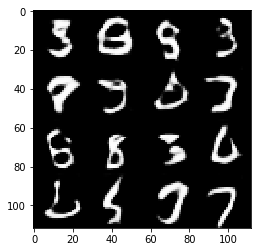

Epoch: 2/2(710)... Discriminator Loss: 0.699039... Generator Loss: 1.390846
Epoch: 2/2(720)... Discriminator Loss: 0.671233... Generator Loss: 2.094365
Epoch: 2/2(730)... Discriminator Loss: 1.171250... Generator Loss: 3.766611
Epoch: 2/2(740)... Discriminator Loss: 0.585289... Generator Loss: 1.995578
Epoch: 2/2(750)... Discriminator Loss: 0.721508... Generator Loss: 1.900499
Epoch: 2/2(760)... Discriminator Loss: 1.394278... Generator Loss: 2.699991
Epoch: 2/2(770)... Discriminator Loss: 0.519325... Generator Loss: 2.422708
Epoch: 2/2(780)... Discriminator Loss: 0.497727... Generator Loss: 2.474205
Epoch: 2/2(790)... Discriminator Loss: 0.851427... Generator Loss: 2.033063
Epoch: 2/2(800)... Discriminator Loss: 1.292428... Generator Loss: 0.987802


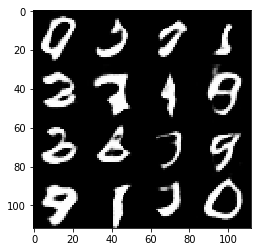

Epoch: 2/2(810)... Discriminator Loss: 0.618118... Generator Loss: 2.302661
Epoch: 2/2(820)... Discriminator Loss: 1.190827... Generator Loss: 0.823456
Epoch: 2/2(830)... Discriminator Loss: 0.676955... Generator Loss: 1.760919
Epoch: 2/2(840)... Discriminator Loss: 0.683183... Generator Loss: 1.661522
Epoch: 2/2(850)... Discriminator Loss: 0.894857... Generator Loss: 1.220303
Epoch: 2/2(860)... Discriminator Loss: 0.613825... Generator Loss: 1.471089
Epoch: 2/2(870)... Discriminator Loss: 0.490474... Generator Loss: 2.729444
Epoch: 2/2(880)... Discriminator Loss: 1.576822... Generator Loss: 0.475700
Epoch: 2/2(890)... Discriminator Loss: 0.636011... Generator Loss: 1.942286
Epoch: 2/2(900)... Discriminator Loss: 0.491035... Generator Loss: 2.326385


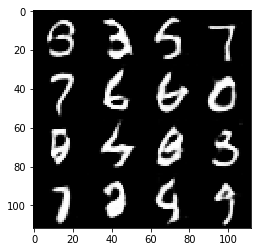

Epoch: 2/2(910)... Discriminator Loss: 3.374848... Generator Loss: 4.377338
Epoch: 2/2(920)... Discriminator Loss: 1.060304... Generator Loss: 1.326304
Epoch: 2/2(930)... Discriminator Loss: 1.368404... Generator Loss: 0.612161


In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1(10)... Discriminator Loss: 1.850438... Generator Loss: 0.574124
Epoch: 1/1(20)... Discriminator Loss: 1.007778... Generator Loss: 1.979996
Epoch: 1/1(30)... Discriminator Loss: 1.079828... Generator Loss: 1.160824
Epoch: 1/1(40)... Discriminator Loss: 1.854673... Generator Loss: 0.532670
Epoch: 1/1(50)... Discriminator Loss: 0.632893... Generator Loss: 2.596589
Epoch: 1/1(60)... Discriminator Loss: 0.577187... Generator Loss: 3.322673
Epoch: 1/1(70)... Discriminator Loss: 0.611111... Generator Loss: 4.356317
Epoch: 1/1(80)... Discriminator Loss: 1.586001... Generator Loss: 4.389768
Epoch: 1/1(90)... Discriminator Loss: 1.257903... Generator Loss: 1.052255
Epoch: 1/1(100)... Discriminator Loss: 1.592669... Generator Loss: 2.142379


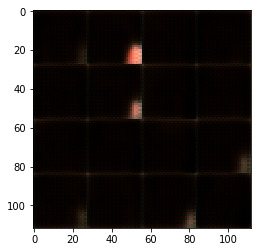

Epoch: 1/1(110)... Discriminator Loss: 1.415451... Generator Loss: 0.959115
Epoch: 1/1(120)... Discriminator Loss: 1.430837... Generator Loss: 1.049906
Epoch: 1/1(130)... Discriminator Loss: 1.398336... Generator Loss: 0.950904
Epoch: 1/1(140)... Discriminator Loss: 1.731718... Generator Loss: 1.077745
Epoch: 1/1(150)... Discriminator Loss: 1.730810... Generator Loss: 0.892325
Epoch: 1/1(160)... Discriminator Loss: 1.550518... Generator Loss: 0.817606
Epoch: 1/1(170)... Discriminator Loss: 1.543431... Generator Loss: 0.813661
Epoch: 1/1(180)... Discriminator Loss: 1.482631... Generator Loss: 0.779234
Epoch: 1/1(190)... Discriminator Loss: 1.386945... Generator Loss: 0.906297
Epoch: 1/1(200)... Discriminator Loss: 1.440446... Generator Loss: 0.804257


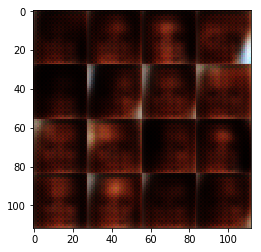

Epoch: 1/1(210)... Discriminator Loss: 1.472408... Generator Loss: 0.885031
Epoch: 1/1(220)... Discriminator Loss: 1.443562... Generator Loss: 1.109161
Epoch: 1/1(230)... Discriminator Loss: 1.708646... Generator Loss: 0.742599
Epoch: 1/1(240)... Discriminator Loss: 1.701254... Generator Loss: 0.769452
Epoch: 1/1(250)... Discriminator Loss: 1.384614... Generator Loss: 0.685419
Epoch: 1/1(260)... Discriminator Loss: 1.417358... Generator Loss: 0.823536
Epoch: 1/1(270)... Discriminator Loss: 1.458252... Generator Loss: 0.758689
Epoch: 1/1(280)... Discriminator Loss: 1.395964... Generator Loss: 0.770259
Epoch: 1/1(290)... Discriminator Loss: 1.501115... Generator Loss: 0.711508
Epoch: 1/1(300)... Discriminator Loss: 1.321099... Generator Loss: 0.842418


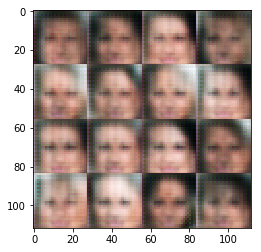

Epoch: 1/1(310)... Discriminator Loss: 1.404458... Generator Loss: 0.899458
Epoch: 1/1(320)... Discriminator Loss: 1.334692... Generator Loss: 0.786791
Epoch: 1/1(330)... Discriminator Loss: 1.347949... Generator Loss: 0.769253
Epoch: 1/1(340)... Discriminator Loss: 1.424405... Generator Loss: 0.705124
Epoch: 1/1(350)... Discriminator Loss: 1.437513... Generator Loss: 0.779551
Epoch: 1/1(360)... Discriminator Loss: 1.365255... Generator Loss: 0.924828
Epoch: 1/1(370)... Discriminator Loss: 1.388336... Generator Loss: 0.808780
Epoch: 1/1(380)... Discriminator Loss: 1.369487... Generator Loss: 0.814250
Epoch: 1/1(390)... Discriminator Loss: 1.448317... Generator Loss: 0.937495
Epoch: 1/1(400)... Discriminator Loss: 1.457294... Generator Loss: 0.717816


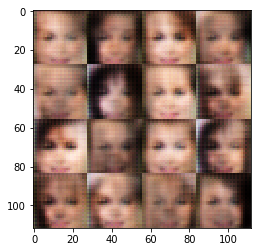

Epoch: 1/1(410)... Discriminator Loss: 1.324395... Generator Loss: 0.664663
Epoch: 1/1(420)... Discriminator Loss: 1.376734... Generator Loss: 0.785950
Epoch: 1/1(430)... Discriminator Loss: 1.390528... Generator Loss: 0.838347
Epoch: 1/1(440)... Discriminator Loss: 1.368415... Generator Loss: 0.732685
Epoch: 1/1(450)... Discriminator Loss: 1.362915... Generator Loss: 0.747530
Epoch: 1/1(460)... Discriminator Loss: 1.405258... Generator Loss: 0.801383
Epoch: 1/1(470)... Discriminator Loss: 1.378708... Generator Loss: 0.757172
Epoch: 1/1(480)... Discriminator Loss: 1.383830... Generator Loss: 0.858748
Epoch: 1/1(490)... Discriminator Loss: 1.391922... Generator Loss: 0.789260
Epoch: 1/1(500)... Discriminator Loss: 1.376800... Generator Loss: 0.890699


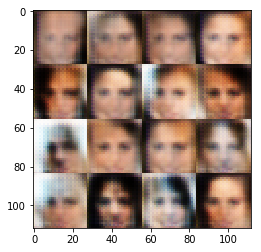

Epoch: 1/1(510)... Discriminator Loss: 1.454622... Generator Loss: 0.808313
Epoch: 1/1(520)... Discriminator Loss: 1.478205... Generator Loss: 0.597480
Epoch: 1/1(530)... Discriminator Loss: 1.348632... Generator Loss: 0.800377
Epoch: 1/1(540)... Discriminator Loss: 1.395419... Generator Loss: 0.781114
Epoch: 1/1(550)... Discriminator Loss: 1.389951... Generator Loss: 0.863187
Epoch: 1/1(560)... Discriminator Loss: 1.421863... Generator Loss: 0.766175
Epoch: 1/1(570)... Discriminator Loss: 1.371534... Generator Loss: 0.904896
Epoch: 1/1(580)... Discriminator Loss: 1.349928... Generator Loss: 0.888527
Epoch: 1/1(590)... Discriminator Loss: 1.414358... Generator Loss: 0.863307
Epoch: 1/1(600)... Discriminator Loss: 1.455815... Generator Loss: 0.672270


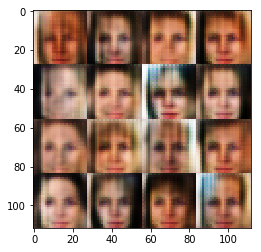

Epoch: 1/1(610)... Discriminator Loss: 1.361282... Generator Loss: 0.863195
Epoch: 1/1(620)... Discriminator Loss: 1.388808... Generator Loss: 0.778517
Epoch: 1/1(630)... Discriminator Loss: 1.361860... Generator Loss: 0.671476
Epoch: 1/1(640)... Discriminator Loss: 1.424617... Generator Loss: 0.761912
Epoch: 1/1(650)... Discriminator Loss: 1.396815... Generator Loss: 0.718156
Epoch: 1/1(660)... Discriminator Loss: 1.375701... Generator Loss: 0.875090
Epoch: 1/1(670)... Discriminator Loss: 1.412724... Generator Loss: 0.613040
Epoch: 1/1(680)... Discriminator Loss: 1.349689... Generator Loss: 0.891925
Epoch: 1/1(690)... Discriminator Loss: 1.348111... Generator Loss: 0.808672
Epoch: 1/1(700)... Discriminator Loss: 1.372325... Generator Loss: 0.846076


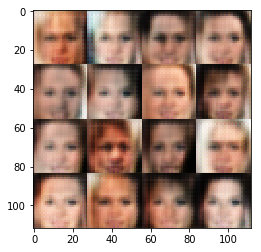

Epoch: 1/1(710)... Discriminator Loss: 1.352296... Generator Loss: 0.941959
Epoch: 1/1(720)... Discriminator Loss: 1.331132... Generator Loss: 0.889211
Epoch: 1/1(730)... Discriminator Loss: 1.357020... Generator Loss: 0.659589
Epoch: 1/1(740)... Discriminator Loss: 1.387205... Generator Loss: 0.651772
Epoch: 1/1(750)... Discriminator Loss: 1.374673... Generator Loss: 0.838737
Epoch: 1/1(760)... Discriminator Loss: 1.416759... Generator Loss: 0.608052
Epoch: 1/1(770)... Discriminator Loss: 1.362763... Generator Loss: 0.744787
Epoch: 1/1(780)... Discriminator Loss: 1.343503... Generator Loss: 0.641194
Epoch: 1/1(790)... Discriminator Loss: 1.397162... Generator Loss: 0.658765
Epoch: 1/1(800)... Discriminator Loss: 1.317142... Generator Loss: 0.833456


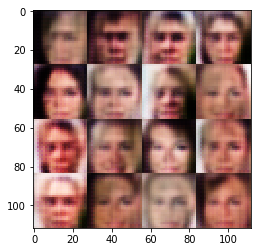

Epoch: 1/1(810)... Discriminator Loss: 1.408452... Generator Loss: 0.593485
Epoch: 1/1(820)... Discriminator Loss: 1.458549... Generator Loss: 1.026691
Epoch: 1/1(830)... Discriminator Loss: 1.355409... Generator Loss: 0.772723
Epoch: 1/1(840)... Discriminator Loss: 1.425501... Generator Loss: 0.767918
Epoch: 1/1(850)... Discriminator Loss: 1.434287... Generator Loss: 0.581523
Epoch: 1/1(860)... Discriminator Loss: 1.346727... Generator Loss: 0.709228
Epoch: 1/1(870)... Discriminator Loss: 1.368433... Generator Loss: 0.776972
Epoch: 1/1(880)... Discriminator Loss: 1.345230... Generator Loss: 0.889077
Epoch: 1/1(890)... Discriminator Loss: 1.377941... Generator Loss: 0.913347
Epoch: 1/1(900)... Discriminator Loss: 1.399731... Generator Loss: 0.940460


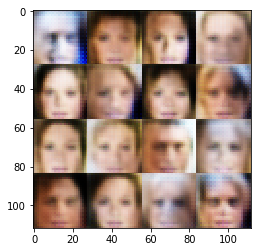

Epoch: 1/1(910)... Discriminator Loss: 1.420836... Generator Loss: 0.619756
Epoch: 1/1(920)... Discriminator Loss: 1.398341... Generator Loss: 0.741790
Epoch: 1/1(930)... Discriminator Loss: 1.428311... Generator Loss: 0.602382
Epoch: 1/1(940)... Discriminator Loss: 1.414460... Generator Loss: 0.673366
Epoch: 1/1(950)... Discriminator Loss: 1.353852... Generator Loss: 0.834728
Epoch: 1/1(960)... Discriminator Loss: 1.352878... Generator Loss: 0.878298
Epoch: 1/1(970)... Discriminator Loss: 1.326063... Generator Loss: 0.705470
Epoch: 1/1(980)... Discriminator Loss: 1.379015... Generator Loss: 0.712814
Epoch: 1/1(990)... Discriminator Loss: 1.422435... Generator Loss: 0.717891
Epoch: 1/1(1000)... Discriminator Loss: 1.367235... Generator Loss: 0.762889


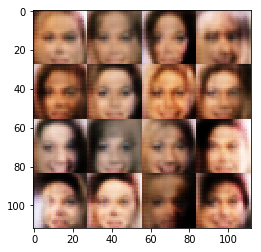

Epoch: 1/1(1010)... Discriminator Loss: 1.386889... Generator Loss: 0.633985
Epoch: 1/1(1020)... Discriminator Loss: 1.358272... Generator Loss: 0.851283
Epoch: 1/1(1030)... Discriminator Loss: 1.331685... Generator Loss: 0.658333
Epoch: 1/1(1040)... Discriminator Loss: 1.395978... Generator Loss: 0.669648
Epoch: 1/1(1050)... Discriminator Loss: 1.372112... Generator Loss: 0.779187
Epoch: 1/1(1060)... Discriminator Loss: 1.416712... Generator Loss: 0.776883
Epoch: 1/1(1070)... Discriminator Loss: 1.367146... Generator Loss: 0.754669
Epoch: 1/1(1080)... Discriminator Loss: 1.368428... Generator Loss: 0.779143
Epoch: 1/1(1090)... Discriminator Loss: 1.387470... Generator Loss: 0.717562
Epoch: 1/1(1100)... Discriminator Loss: 1.359744... Generator Loss: 0.800469


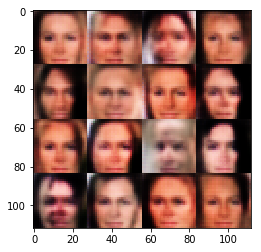

Epoch: 1/1(1110)... Discriminator Loss: 1.350294... Generator Loss: 0.814008
Epoch: 1/1(1120)... Discriminator Loss: 1.331743... Generator Loss: 0.775239
Epoch: 1/1(1130)... Discriminator Loss: 1.392972... Generator Loss: 0.774942
Epoch: 1/1(1140)... Discriminator Loss: 1.400718... Generator Loss: 0.893328
Epoch: 1/1(1150)... Discriminator Loss: 1.390996... Generator Loss: 0.889368
Epoch: 1/1(1160)... Discriminator Loss: 1.390800... Generator Loss: 0.825377
Epoch: 1/1(1170)... Discriminator Loss: 1.363013... Generator Loss: 0.767948
Epoch: 1/1(1180)... Discriminator Loss: 1.378152... Generator Loss: 0.871788
Epoch: 1/1(1190)... Discriminator Loss: 1.439211... Generator Loss: 0.970589
Epoch: 1/1(1200)... Discriminator Loss: 1.586963... Generator Loss: 0.445793


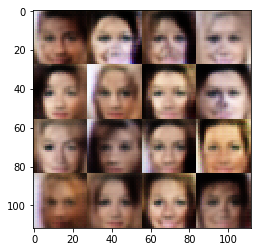

Epoch: 1/1(1210)... Discriminator Loss: 1.358845... Generator Loss: 0.840982
Epoch: 1/1(1220)... Discriminator Loss: 1.419728... Generator Loss: 0.873353
Epoch: 1/1(1230)... Discriminator Loss: 1.408459... Generator Loss: 0.692490
Epoch: 1/1(1240)... Discriminator Loss: 1.362806... Generator Loss: 0.605519
Epoch: 1/1(1250)... Discriminator Loss: 1.340482... Generator Loss: 1.219812
Epoch: 1/1(1260)... Discriminator Loss: 1.385353... Generator Loss: 0.801952
Epoch: 1/1(1270)... Discriminator Loss: 1.314499... Generator Loss: 0.762637
Epoch: 1/1(1280)... Discriminator Loss: 1.396998... Generator Loss: 0.778585
Epoch: 1/1(1290)... Discriminator Loss: 1.383945... Generator Loss: 0.802116
Epoch: 1/1(1300)... Discriminator Loss: 1.377141... Generator Loss: 0.819827


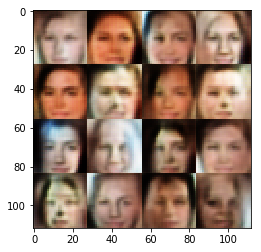

Epoch: 1/1(1310)... Discriminator Loss: 1.387217... Generator Loss: 0.699564
Epoch: 1/1(1320)... Discriminator Loss: 1.408793... Generator Loss: 0.969758
Epoch: 1/1(1330)... Discriminator Loss: 1.357190... Generator Loss: 0.655649
Epoch: 1/1(1340)... Discriminator Loss: 1.378617... Generator Loss: 0.856069
Epoch: 1/1(1350)... Discriminator Loss: 1.348348... Generator Loss: 0.769050
Epoch: 1/1(1360)... Discriminator Loss: 1.369558... Generator Loss: 0.795081
Epoch: 1/1(1370)... Discriminator Loss: 1.368451... Generator Loss: 0.553639
Epoch: 1/1(1380)... Discriminator Loss: 1.326170... Generator Loss: 0.871853
Epoch: 1/1(1390)... Discriminator Loss: 1.359588... Generator Loss: 0.758353
Epoch: 1/1(1400)... Discriminator Loss: 1.410488... Generator Loss: 0.721422


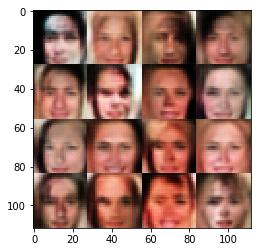

Epoch: 1/1(1410)... Discriminator Loss: 1.346442... Generator Loss: 0.699955
Epoch: 1/1(1420)... Discriminator Loss: 1.365784... Generator Loss: 0.806675
Epoch: 1/1(1430)... Discriminator Loss: 1.351952... Generator Loss: 0.905124
Epoch: 1/1(1440)... Discriminator Loss: 1.437600... Generator Loss: 0.620201
Epoch: 1/1(1450)... Discriminator Loss: 1.484965... Generator Loss: 0.904313
Epoch: 1/1(1460)... Discriminator Loss: 1.361608... Generator Loss: 0.619342
Epoch: 1/1(1470)... Discriminator Loss: 1.416945... Generator Loss: 0.817164
Epoch: 1/1(1480)... Discriminator Loss: 1.346206... Generator Loss: 0.739305
Epoch: 1/1(1490)... Discriminator Loss: 1.379691... Generator Loss: 0.872595
Epoch: 1/1(1500)... Discriminator Loss: 1.291193... Generator Loss: 0.838770


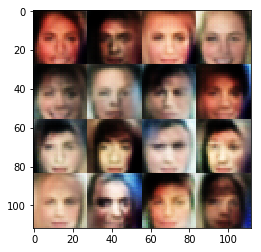

Epoch: 1/1(1510)... Discriminator Loss: 1.394803... Generator Loss: 0.673558
Epoch: 1/1(1520)... Discriminator Loss: 1.329070... Generator Loss: 0.739563
Epoch: 1/1(1530)... Discriminator Loss: 1.360587... Generator Loss: 0.879775
Epoch: 1/1(1540)... Discriminator Loss: 1.324691... Generator Loss: 0.761293
Epoch: 1/1(1550)... Discriminator Loss: 1.377443... Generator Loss: 0.764972
Epoch: 1/1(1560)... Discriminator Loss: 1.385933... Generator Loss: 0.799059
Epoch: 1/1(1570)... Discriminator Loss: 1.389778... Generator Loss: 0.769541
Epoch: 1/1(1580)... Discriminator Loss: 1.362740... Generator Loss: 0.653833
Epoch: 1/1(1590)... Discriminator Loss: 1.384381... Generator Loss: 0.655348
Epoch: 1/1(1600)... Discriminator Loss: 1.314059... Generator Loss: 0.808563


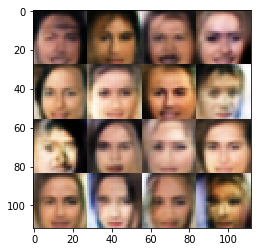

Epoch: 1/1(1610)... Discriminator Loss: 1.396313... Generator Loss: 0.760382
Epoch: 1/1(1620)... Discriminator Loss: 1.386818... Generator Loss: 0.710417
Epoch: 1/1(1630)... Discriminator Loss: 1.420067... Generator Loss: 1.038604
Epoch: 1/1(1640)... Discriminator Loss: 1.640408... Generator Loss: 0.490270
Epoch: 1/1(1650)... Discriminator Loss: 1.383600... Generator Loss: 0.750313
Epoch: 1/1(1660)... Discriminator Loss: 1.393644... Generator Loss: 0.696200
Epoch: 1/1(1670)... Discriminator Loss: 1.332515... Generator Loss: 0.741559
Epoch: 1/1(1680)... Discriminator Loss: 1.390191... Generator Loss: 0.594885
Epoch: 1/1(1690)... Discriminator Loss: 1.472383... Generator Loss: 0.635688
Epoch: 1/1(1700)... Discriminator Loss: 1.614881... Generator Loss: 0.513739


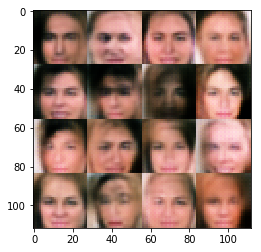

Epoch: 1/1(1710)... Discriminator Loss: 1.376310... Generator Loss: 0.853353
Epoch: 1/1(1720)... Discriminator Loss: 1.339092... Generator Loss: 0.811519
Epoch: 1/1(1730)... Discriminator Loss: 1.414854... Generator Loss: 0.632013
Epoch: 1/1(1740)... Discriminator Loss: 1.322670... Generator Loss: 0.899604
Epoch: 1/1(1750)... Discriminator Loss: 1.400484... Generator Loss: 0.844380
Epoch: 1/1(1760)... Discriminator Loss: 1.341112... Generator Loss: 0.791061
Epoch: 1/1(1770)... Discriminator Loss: 1.403962... Generator Loss: 0.699203
Epoch: 1/1(1780)... Discriminator Loss: 1.385133... Generator Loss: 0.595309
Epoch: 1/1(1790)... Discriminator Loss: 1.376132... Generator Loss: 0.851979
Epoch: 1/1(1800)... Discriminator Loss: 1.494842... Generator Loss: 0.682164


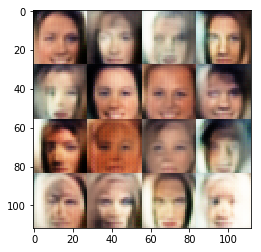

Epoch: 1/1(1810)... Discriminator Loss: 1.385867... Generator Loss: 0.776227
Epoch: 1/1(1820)... Discriminator Loss: 1.366498... Generator Loss: 0.890466
Epoch: 1/1(1830)... Discriminator Loss: 1.457000... Generator Loss: 0.594960
Epoch: 1/1(1840)... Discriminator Loss: 1.391369... Generator Loss: 0.939207
Epoch: 1/1(1850)... Discriminator Loss: 1.377905... Generator Loss: 0.673658
Epoch: 1/1(1860)... Discriminator Loss: 1.329029... Generator Loss: 1.006440
Epoch: 1/1(1870)... Discriminator Loss: 1.411941... Generator Loss: 0.643954
Epoch: 1/1(1880)... Discriminator Loss: 1.384743... Generator Loss: 0.731073
Epoch: 1/1(1890)... Discriminator Loss: 1.497417... Generator Loss: 0.528949
Epoch: 1/1(1900)... Discriminator Loss: 1.397053... Generator Loss: 0.877088


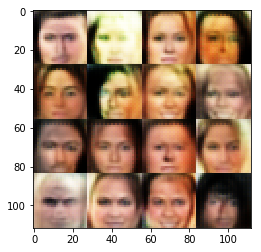

Epoch: 1/1(1910)... Discriminator Loss: 1.372930... Generator Loss: 0.765781
Epoch: 1/1(1920)... Discriminator Loss: 1.356312... Generator Loss: 0.719185
Epoch: 1/1(1930)... Discriminator Loss: 1.441354... Generator Loss: 0.648693
Epoch: 1/1(1940)... Discriminator Loss: 1.382246... Generator Loss: 0.745192
Epoch: 1/1(1950)... Discriminator Loss: 1.422008... Generator Loss: 0.758970
Epoch: 1/1(1960)... Discriminator Loss: 1.387532... Generator Loss: 0.807416
Epoch: 1/1(1970)... Discriminator Loss: 1.381087... Generator Loss: 0.732032
Epoch: 1/1(1980)... Discriminator Loss: 1.375311... Generator Loss: 0.752070
Epoch: 1/1(1990)... Discriminator Loss: 1.380242... Generator Loss: 0.719627
Epoch: 1/1(2000)... Discriminator Loss: 1.389460... Generator Loss: 0.873423


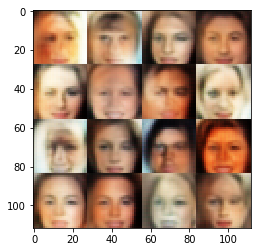

Epoch: 1/1(2010)... Discriminator Loss: 1.401785... Generator Loss: 0.752589
Epoch: 1/1(2020)... Discriminator Loss: 1.380918... Generator Loss: 0.841249
Epoch: 1/1(2030)... Discriminator Loss: 1.340463... Generator Loss: 0.775771
Epoch: 1/1(2040)... Discriminator Loss: 1.385502... Generator Loss: 0.792384
Epoch: 1/1(2050)... Discriminator Loss: 1.345519... Generator Loss: 0.784636
Epoch: 1/1(2060)... Discriminator Loss: 1.357791... Generator Loss: 0.834381
Epoch: 1/1(2070)... Discriminator Loss: 1.355512... Generator Loss: 0.787948
Epoch: 1/1(2080)... Discriminator Loss: 1.381253... Generator Loss: 0.722393
Epoch: 1/1(2090)... Discriminator Loss: 1.309055... Generator Loss: 0.728167
Epoch: 1/1(2100)... Discriminator Loss: 1.343867... Generator Loss: 0.637024


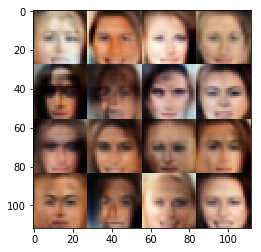

Epoch: 1/1(2110)... Discriminator Loss: 1.366011... Generator Loss: 0.838621
Epoch: 1/1(2120)... Discriminator Loss: 1.399305... Generator Loss: 0.852474
Epoch: 1/1(2130)... Discriminator Loss: 1.331219... Generator Loss: 0.795109
Epoch: 1/1(2140)... Discriminator Loss: 1.382261... Generator Loss: 0.763437
Epoch: 1/1(2150)... Discriminator Loss: 1.391550... Generator Loss: 0.751895
Epoch: 1/1(2160)... Discriminator Loss: 1.375868... Generator Loss: 0.866106
Epoch: 1/1(2170)... Discriminator Loss: 1.375737... Generator Loss: 0.864753
Epoch: 1/1(2180)... Discriminator Loss: 1.390582... Generator Loss: 0.682880
Epoch: 1/1(2190)... Discriminator Loss: 1.444559... Generator Loss: 0.569574
Epoch: 1/1(2200)... Discriminator Loss: 1.293047... Generator Loss: 0.579303


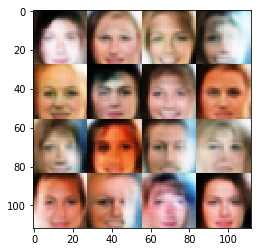

Epoch: 1/1(2210)... Discriminator Loss: 1.411807... Generator Loss: 0.825437
Epoch: 1/1(2220)... Discriminator Loss: 1.389209... Generator Loss: 0.817964
Epoch: 1/1(2230)... Discriminator Loss: 1.409721... Generator Loss: 0.835814
Epoch: 1/1(2240)... Discriminator Loss: 1.390734... Generator Loss: 0.697686
Epoch: 1/1(2250)... Discriminator Loss: 1.394935... Generator Loss: 0.750841
Epoch: 1/1(2260)... Discriminator Loss: 1.376143... Generator Loss: 0.754922
Epoch: 1/1(2270)... Discriminator Loss: 1.347593... Generator Loss: 0.768118
Epoch: 1/1(2280)... Discriminator Loss: 1.373706... Generator Loss: 0.906595
Epoch: 1/1(2290)... Discriminator Loss: 1.411755... Generator Loss: 0.692083
Epoch: 1/1(2300)... Discriminator Loss: 1.407422... Generator Loss: 0.928747


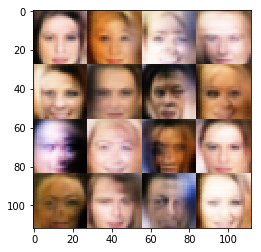

Epoch: 1/1(2310)... Discriminator Loss: 1.349088... Generator Loss: 0.767808
Epoch: 1/1(2320)... Discriminator Loss: 1.358260... Generator Loss: 0.873727
Epoch: 1/1(2330)... Discriminator Loss: 1.358503... Generator Loss: 0.749575
Epoch: 1/1(2340)... Discriminator Loss: 1.375518... Generator Loss: 0.758895
Epoch: 1/1(2350)... Discriminator Loss: 1.415670... Generator Loss: 0.677135
Epoch: 1/1(2360)... Discriminator Loss: 1.381085... Generator Loss: 0.732124
Epoch: 1/1(2370)... Discriminator Loss: 1.400187... Generator Loss: 0.727033
Epoch: 1/1(2380)... Discriminator Loss: 1.389080... Generator Loss: 0.788425
Epoch: 1/1(2390)... Discriminator Loss: 1.350906... Generator Loss: 0.846329
Epoch: 1/1(2400)... Discriminator Loss: 1.372887... Generator Loss: 0.796306


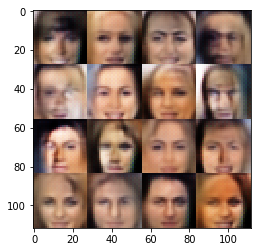

Epoch: 1/1(2410)... Discriminator Loss: 1.423721... Generator Loss: 0.619993
Epoch: 1/1(2420)... Discriminator Loss: 1.355618... Generator Loss: 0.676724
Epoch: 1/1(2430)... Discriminator Loss: 1.475198... Generator Loss: 0.603614
Epoch: 1/1(2440)... Discriminator Loss: 1.359531... Generator Loss: 0.600721
Epoch: 1/1(2450)... Discriminator Loss: 1.388960... Generator Loss: 0.725661
Epoch: 1/1(2460)... Discriminator Loss: 1.368449... Generator Loss: 0.930299
Epoch: 1/1(2470)... Discriminator Loss: 1.366817... Generator Loss: 0.743618
Epoch: 1/1(2480)... Discriminator Loss: 1.409370... Generator Loss: 0.623348
Epoch: 1/1(2490)... Discriminator Loss: 1.320655... Generator Loss: 0.744853
Epoch: 1/1(2500)... Discriminator Loss: 1.361676... Generator Loss: 0.808558


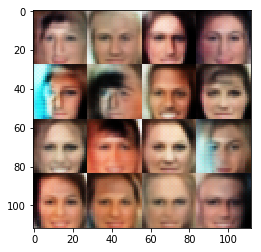

Epoch: 1/1(2510)... Discriminator Loss: 1.344023... Generator Loss: 0.677290
Epoch: 1/1(2520)... Discriminator Loss: 1.378991... Generator Loss: 0.695974
Epoch: 1/1(2530)... Discriminator Loss: 1.357334... Generator Loss: 0.769107
Epoch: 1/1(2540)... Discriminator Loss: 1.404553... Generator Loss: 0.686253
Epoch: 1/1(2550)... Discriminator Loss: 1.292175... Generator Loss: 0.811957
Epoch: 1/1(2560)... Discriminator Loss: 1.486732... Generator Loss: 0.575740
Epoch: 1/1(2570)... Discriminator Loss: 1.443542... Generator Loss: 0.746212
Epoch: 1/1(2580)... Discriminator Loss: 1.381795... Generator Loss: 0.765644
Epoch: 1/1(2590)... Discriminator Loss: 1.376676... Generator Loss: 0.810484
Epoch: 1/1(2600)... Discriminator Loss: 1.386392... Generator Loss: 0.762287


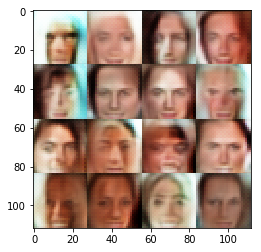

Epoch: 1/1(2610)... Discriminator Loss: 1.359715... Generator Loss: 0.788428
Epoch: 1/1(2620)... Discriminator Loss: 1.367225... Generator Loss: 0.875748
Epoch: 1/1(2630)... Discriminator Loss: 1.345820... Generator Loss: 0.679646
Epoch: 1/1(2640)... Discriminator Loss: 1.363579... Generator Loss: 0.734317
Epoch: 1/1(2650)... Discriminator Loss: 1.398127... Generator Loss: 0.719627
Epoch: 1/1(2660)... Discriminator Loss: 1.375268... Generator Loss: 0.906935
Epoch: 1/1(2670)... Discriminator Loss: 1.298309... Generator Loss: 0.712200
Epoch: 1/1(2680)... Discriminator Loss: 1.358237... Generator Loss: 0.868196
Epoch: 1/1(2690)... Discriminator Loss: 1.431265... Generator Loss: 0.700102
Epoch: 1/1(2700)... Discriminator Loss: 1.311339... Generator Loss: 0.838245


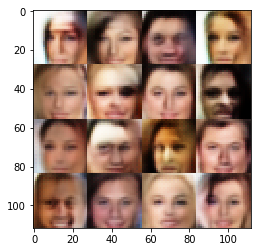

Epoch: 1/1(2710)... Discriminator Loss: 1.311555... Generator Loss: 0.812878
Epoch: 1/1(2720)... Discriminator Loss: 1.334895... Generator Loss: 0.755880
Epoch: 1/1(2730)... Discriminator Loss: 1.364108... Generator Loss: 0.979626
Epoch: 1/1(2740)... Discriminator Loss: 1.306624... Generator Loss: 0.721127
Epoch: 1/1(2750)... Discriminator Loss: 1.343103... Generator Loss: 0.836190
Epoch: 1/1(2760)... Discriminator Loss: 1.428847... Generator Loss: 0.577288
Epoch: 1/1(2770)... Discriminator Loss: 1.432478... Generator Loss: 0.662785
Epoch: 1/1(2780)... Discriminator Loss: 1.419071... Generator Loss: 0.644310
Epoch: 1/1(2790)... Discriminator Loss: 1.371474... Generator Loss: 0.812902
Epoch: 1/1(2800)... Discriminator Loss: 1.363428... Generator Loss: 0.876693


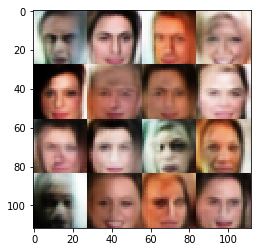

Epoch: 1/1(2810)... Discriminator Loss: 1.449198... Generator Loss: 0.681284
Epoch: 1/1(2820)... Discriminator Loss: 1.358407... Generator Loss: 0.749308
Epoch: 1/1(2830)... Discriminator Loss: 1.336875... Generator Loss: 0.802084
Epoch: 1/1(2840)... Discriminator Loss: 1.377380... Generator Loss: 0.737703
Epoch: 1/1(2850)... Discriminator Loss: 1.425720... Generator Loss: 0.691339
Epoch: 1/1(2860)... Discriminator Loss: 1.402180... Generator Loss: 0.645317
Epoch: 1/1(2870)... Discriminator Loss: 1.328734... Generator Loss: 0.685136
Epoch: 1/1(2880)... Discriminator Loss: 1.356113... Generator Loss: 0.769540
Epoch: 1/1(2890)... Discriminator Loss: 1.331843... Generator Loss: 0.732880
Epoch: 1/1(2900)... Discriminator Loss: 1.380455... Generator Loss: 0.785494


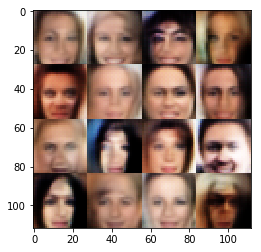

Epoch: 1/1(2910)... Discriminator Loss: 1.339054... Generator Loss: 0.787751
Epoch: 1/1(2920)... Discriminator Loss: 1.340220... Generator Loss: 0.984881
Epoch: 1/1(2930)... Discriminator Loss: 1.321509... Generator Loss: 0.798011
Epoch: 1/1(2940)... Discriminator Loss: 1.300780... Generator Loss: 0.732584
Epoch: 1/1(2950)... Discriminator Loss: 1.367499... Generator Loss: 0.774070
Epoch: 1/1(2960)... Discriminator Loss: 1.399611... Generator Loss: 0.617395
Epoch: 1/1(2970)... Discriminator Loss: 1.320892... Generator Loss: 0.806418
Epoch: 1/1(2980)... Discriminator Loss: 1.398010... Generator Loss: 0.780172
Epoch: 1/1(2990)... Discriminator Loss: 1.347346... Generator Loss: 0.719023
Epoch: 1/1(3000)... Discriminator Loss: 1.353367... Generator Loss: 0.896583


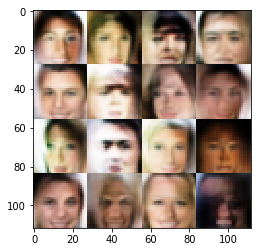

Epoch: 1/1(3010)... Discriminator Loss: 1.239239... Generator Loss: 0.840706
Epoch: 1/1(3020)... Discriminator Loss: 1.382986... Generator Loss: 0.715676
Epoch: 1/1(3030)... Discriminator Loss: 1.356768... Generator Loss: 0.731446
Epoch: 1/1(3040)... Discriminator Loss: 1.402933... Generator Loss: 0.991586
Epoch: 1/1(3050)... Discriminator Loss: 1.373103... Generator Loss: 0.828606
Epoch: 1/1(3060)... Discriminator Loss: 1.406410... Generator Loss: 0.700843
Epoch: 1/1(3070)... Discriminator Loss: 1.308333... Generator Loss: 0.739941
Epoch: 1/1(3080)... Discriminator Loss: 1.306262... Generator Loss: 0.778105
Epoch: 1/1(3090)... Discriminator Loss: 1.342631... Generator Loss: 0.754806
Epoch: 1/1(3100)... Discriminator Loss: 1.336646... Generator Loss: 0.782937


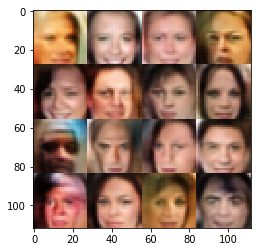

Epoch: 1/1(3110)... Discriminator Loss: 1.388585... Generator Loss: 0.835996
Epoch: 1/1(3120)... Discriminator Loss: 1.290242... Generator Loss: 0.788598
Epoch: 1/1(3130)... Discriminator Loss: 1.416120... Generator Loss: 0.898193
Epoch: 1/1(3140)... Discriminator Loss: 1.370229... Generator Loss: 0.868807
Epoch: 1/1(3150)... Discriminator Loss: 1.336304... Generator Loss: 0.770598
Epoch: 1/1(3160)... Discriminator Loss: 1.350032... Generator Loss: 0.794789


In [39]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.